<a href="https://colab.research.google.com/github/DDiekmann/Applied-Verification-Lab-Neural-Networks/blob/main/Tutorials/Tutorial_for_Neural_Network_Verification_with_Marabou.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial for Neural Network Verification with Marabou

---

*As an example we try to verifiy the **robustness** of a classification Network trained on the MNIST dataset using the [Marabou library](https://github.com/NeuralNetworkVerification/Marabou).*

[Marabou documenation](https://neuralnetworkverification.github.io/Marabou/)

---

In [23]:
import torch
from torch import nn
import numpy as np

import torch.onnx

## Neural Network Training

In [3]:
%%capture

!wget --no-cache --backups=1 {'https://raw.githubusercontent.com/DDiekmann/Applied-Verification-Lab-Neural-Networks/main/lib/mnist_trainer.py'}

In [4]:
import mnist_trainer

First, we will train a neural network with the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, number_of_neurons):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, number_of_neurons),
            nn.ReLU(),
            nn.Linear(number_of_neurons, number_of_neurons),
            nn.ReLU(),
            nn.Linear(number_of_neurons, output_dim),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [7]:
%%capture
train_dataloader, test_dataloader = mnist_trainer.load_dataset(batch_size=64)

In [8]:
model = mnist_trainer.train_model(
    NeuralNetwork(input_dim=28*28, output_dim=10, number_of_neurons=20), 
    epochs=3, 
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    )

Epoch 1
-------------------------------


100%|██████████| 938/938 [00:06<00:00, 153.75it/s]


Test Error: 
 Accuracy: 90.8%, Avg loss: 0.309221 

Epoch 2
-------------------------------


100%|██████████| 938/938 [00:06<00:00, 155.62it/s]


Test Error: 
 Accuracy: 92.6%, Avg loss: 0.245993 

Epoch 3
-------------------------------


100%|██████████| 938/938 [00:05<00:00, 156.78it/s]


Test Error: 
 Accuracy: 93.2%, Avg loss: 0.215528 

Done!


## Export the neural network

In [9]:
%pip install onnx onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 8.1 MB/s 
     |████████████████████████████████| 5.2 MB 59.1 MB/s 


In [10]:
model_filename = "mnist_net.onnx"

# set model to eval mode
model.eval()

# create a dummy input in the shape of the input values
device = "cuda" if torch.cuda.is_available() else "cpu"
dummy_input = torch.randn(1, 28, 28).to(device)

torch.onnx.export(model,
                  dummy_input,
                  model_filename,
                  export_params=True,
                  verbose=False,
                  input_names=['image'],
                  output_names=['classification'],
                  )

## Installing Marabou

In [20]:
!git clone https://github.com/NeuralNetworkVerification/Marabou.git
!cd Marabou && git checkout "492c1b8c703c8a383f421468a104c34710e6d26d"

fatal: destination path 'Marabou' already exists and is not an empty directory.
HEAD is now at 492c1b8c Remove ConstraintBoundTightener (#560)


The following script builds and installs marabou. It works in Google Colab (%%shell is colab specific) and takes about 15 minutes there.

In [21]:
%%shell
cd Marabou
mkdir build
cd build
cmake .. -DBUILD_PYTHON=ON
cmake --build .
cd /content

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
                   LWORK_DORMBR=DUM(1)
                               1
dgelss.f:355:31:

                   LWORK_DORGBR=DUM(1)
                               1
dgelss.f:444:0:

          IF( M.GE.MNTHR ) THEN
 
dgeqlf.f:158:0:

      $                   MU, NB, NBMIN, NU, NX
 
dgerqf.f:158:0:

      $                   MU, NB, NBMIN, NU, NX
 
dgesvd.f:3472:0:

          IF( IE.LT.2 ) THEN
 
dgesvd.f:240:0:

      $                   NRVT, WRKBL
 
dgesvd.f:677:0:

          IF( M.GE.MNTHR ) THEN
 
dgesvd.f:237:0:

       INTEGER            BDSPAC, BLK, CHUNK, I, IE, IERR, IR, ISCL,
 
dgesvdx.f:670:0:

          IF( N.GE.MNTHR ) THEN
 
dgesvx.f:441:0:

                ROWCND = MAX( RCMIN, SMLNUM ) / MIN( RCMAX, BIGNUM )
 
dgesvx.f:441:0: Warning: ‘bignum’ may be used uninitialized in this function [-Wmaybe-uninitialized]
dgetc2.f:222:0:

          A( N, N ) = SMIN
 
dgetc2.f:204:0:

      $      CALL DSWAP( N, A( 1, JPV

add marabou to pythonpath

In [24]:
import sys
sys.path.insert(1, '/content/Marabou')

https://neuralnetworkverification.github.io/Marabou/Examples/2_ONNXExample.html

## Verify Robustness using Marabou

import marabou

In [132]:
from maraboupy import Marabou

In [133]:
options = Marabou.createOptions(verbosity = 0)

load network in onnx format in marabou

In [134]:
network = Marabou.read_onnx(model_filename)

choose a fixed input image

In [135]:
inputs, classes = next(iter(train_dataloader))
image = inputs[0].numpy()[0]
correct_class = classes[0].numpy()

predict with network

In [136]:
network_ouput = network.evaluateWithoutMarabou([image])[0]
predicted_class = np.argmax(network_ouput)

plot the image

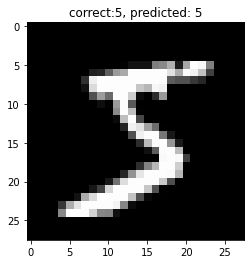

In [137]:
import matplotlib.pyplot as plt
plt.title(f"correct:{correct_class}, predicted: {predicted_class}")
plt.imshow(image.reshape(28,28), cmap='gray')

choose epsilon

In [138]:
epsilon = 0.2

get input and output marabou variables from network

In [139]:
inputVars = network.inputVars[0][0]
outputVars = network.outputVars[0][0]

robustness

input constraints

In [140]:
for h in range(inputVars.shape[0]):
  for w in range(inputVars.shape[1]):
    network.setLowerBound(inputVars[h][w], image[h][w] - epsilon)
    network.setUpperBound(inputVars[h][w], image[h][w] + epsilon)

output constraints

In [141]:
#TODO fix output constraint

#for h in range(outputVars.shape[0]):
#  network.setUpperBound(outputVars[h], outputVars[correct_class])
#network.addMaxConstraint(set(outputVars), outputVars[correct_class])

solve with marabou

In [142]:
exit_code, vals, stats = network.solve(options = options)

sat
input 0 = -0.2
input 1 = -0.2
input 2 = -0.2
input 3 = -0.2
input 4 = -0.2
input 5 = -0.2
input 6 = -0.2
input 7 = -0.2
input 8 = -0.2
input 9 = -0.2
input 10 = -0.2
input 11 = -0.2
input 12 = -0.2
input 13 = -0.2
input 14 = -0.2
input 15 = -0.2
input 16 = -0.2
input 17 = -0.2
input 18 = -0.2
input 19 = -0.2
input 20 = -0.2
input 21 = -0.2
input 22 = -0.2
input 23 = -0.2
input 24 = -0.2
input 25 = -0.2
input 26 = -0.2
input 27 = -0.2
input 28 = -0.2
input 29 = -0.2
input 30 = -0.2
input 31 = -0.2
input 32 = -0.2
input 33 = -0.2
input 34 = -0.2
input 35 = -0.2
input 36 = -0.2
input 37 = -0.2
input 38 = -0.2
input 39 = -0.2
input 40 = 0.2
input 41 = 0.2
input 42 = -0.2
input 43 = -0.2
input 44 = -0.2
input 45 = -0.2
input 46 = -0.2
input 47 = -0.2
input 48 = -0.2
input 49 = -0.2
input 50 = -0.2
input 51 = -0.2
input 52 = -0.2
input 53 = -0.2
input 54 = -0.2
input 55 = -0.2
input 56 = -0.2
input 57 = -0.2
input 58 = -0.2
input 59 = -0.2
input 60 = -0.2
input 61 = -0.2
input 62 = 0.2
i

get image from marabou vals output

In [143]:
adversarial_image = [[] for _ in range(inputVars.shape[1])]
for h in range(inputVars.shape[0]):
  for w in range(inputVars.shape[1]):
    adversarial_image[h].insert(w, vals[inputVars[h][w]])
adversarial_image = np.array(adversarial_image)

get output from marabou

In [144]:
outputs = []
for h in range(outputVars.shape[0]):
  outputs.insert(h, vals[outputVars[h]])
print(outputs)
print(np.argmax(outputs))

[-0.26923681962810553, -3.6689132437146905, -1.4181677448885393, -3.1172551048819597, -3.633513712945729, -0.6755239405395678, -1.9695044054189896, 0.7352352216432805, -0.5222737994858648, -2.052527098406941]
7


show adversarial example

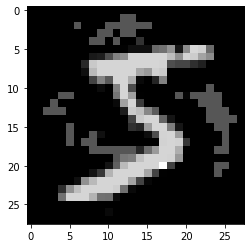

In [145]:
plt.imshow(adversarial_image, cmap='gray')

predict adversarial example with network

In [146]:
network_ouput = network.evaluateWithoutMarabou([adversarial_image])[0]
predicted_class = np.argmax(network_ouput)
print(predicted_class)

7
